In [1]:
import argparse
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import distribute as dist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    Normalization,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

2024-02-09 16:42:52.469705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 16:42:52.500945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 16:42:52.501829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 16:42:53.103787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open("config.json", "r") as file:
    config = json.load(file)

for key in config.keys():
    print(f"{key}:\t{config[key]}")

data_prefix:	/data/
dir_select:	['file_1', 'file_2', 'file_3', 'file_4']
input_len:	4096
materials:	['acrylic', 'metal']
epoch_num:	75
batch_num:	128


In [3]:
Xscaler = Normalization(axis=2)


def model(input_shape=(4096, 1), latent_dim=1, kernel=6, strides=4):
    mapper_input = Input(shape=input_shape)
    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = Conv1D(1, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(2, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(4, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(8, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Conv1D(16, kernel, strides=strides, padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    # x = Dropout(0.1)(x)

    x = Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = Dense(latent_dim, activation="linear")(x)

    return Model(mapper_input, mapper_output)

In [4]:
model = model(latent_dim=1, kernel=6)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 1)]         0         
                                                                 
 normalization (Normalizati  (None, 4096, 1)           3         
 on)                                                             
                                                                 
 conv1d (Conv1D)             (None, 1024, 1)           7         
                                                                 
 batch_normalization (Batch  (None, 1024, 1)           4         
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1024, 1)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 2)            14    

2024-02-09 16:42:53.649869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
X = list()
y = list()

for _ in range(1000):
    X.append(np.random.random(64**2) + 0.1)
    y.append(1)
    X.append(np.random.random(64**2) - 0.1)
    y.append(0)

X = np.array(X)
y = np.array(y)

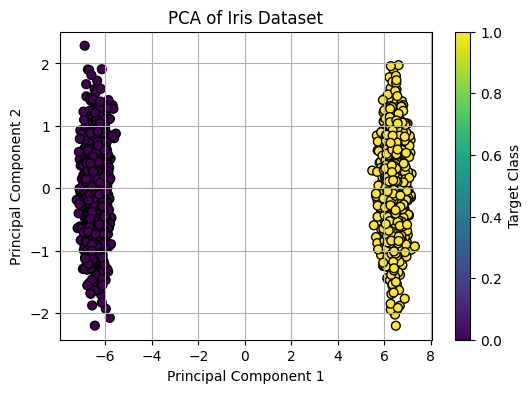

In [6]:
# Perform PCA
pca = PCA(
    n_components=2
)  # You can change the number of components according to your needs
X_pca = pca.fit_transform(X)

# Plot PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Iris Dataset")
plt.colorbar(label="Target Class")
plt.grid(True)
plt.show()

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

In [8]:
es = EarlyStopping(monitor="loss", mode="min", patience=10, restore_best_weights=True)
Xscaler.adapt(X)  # X_train

history = model.fit(
    X_train,
    y_train,
    # validation_data=(X_valid, y_valid),
    epochs=config["epoch_num"],
    batch_size=config["batch_num"],
    callbacks=[es],
    verbose=2,
)

Epoch 1/75
15/15 - 1s - loss: 1.8160 - 1s/epoch - 95ms/step
Epoch 2/75
15/15 - 0s - loss: 0.9729 - 171ms/epoch - 11ms/step
Epoch 3/75
15/15 - 0s - loss: 0.5406 - 178ms/epoch - 12ms/step
Epoch 4/75
15/15 - 0s - loss: 0.3186 - 175ms/epoch - 12ms/step
Epoch 5/75
15/15 - 0s - loss: 0.2009 - 165ms/epoch - 11ms/step
Epoch 6/75
15/15 - 0s - loss: 0.1408 - 177ms/epoch - 12ms/step
Epoch 7/75
15/15 - 0s - loss: 0.1055 - 161ms/epoch - 11ms/step
Epoch 8/75
15/15 - 0s - loss: 0.0841 - 181ms/epoch - 12ms/step
Epoch 9/75
15/15 - 0s - loss: 0.0695 - 166ms/epoch - 11ms/step
Epoch 10/75
15/15 - 0s - loss: 0.0595 - 169ms/epoch - 11ms/step
Epoch 11/75
15/15 - 0s - loss: 0.0512 - 160ms/epoch - 11ms/step
Epoch 12/75
15/15 - 0s - loss: 0.0453 - 158ms/epoch - 11ms/step
Epoch 13/75
15/15 - 0s - loss: 0.0386 - 151ms/epoch - 10ms/step
Epoch 14/75
15/15 - 0s - loss: 0.0330 - 148ms/epoch - 10ms/step
Epoch 15/75
15/15 - 0s - loss: 0.0301 - 146ms/epoch - 10ms/step
Epoch 16/75
15/15 - 0s - loss: 0.0277 - 151ms/epoch 

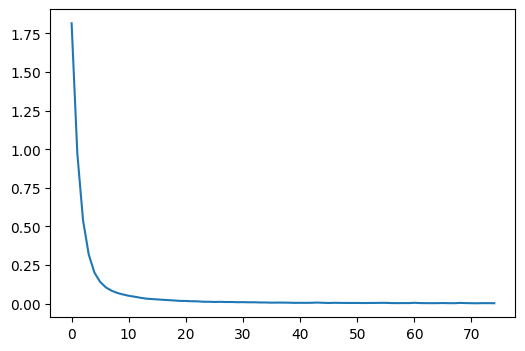

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"])
plt.show()

In [10]:
preds = np.round(model.predict(X_valid))

7/7 [==============================] - 0s 2ms/step


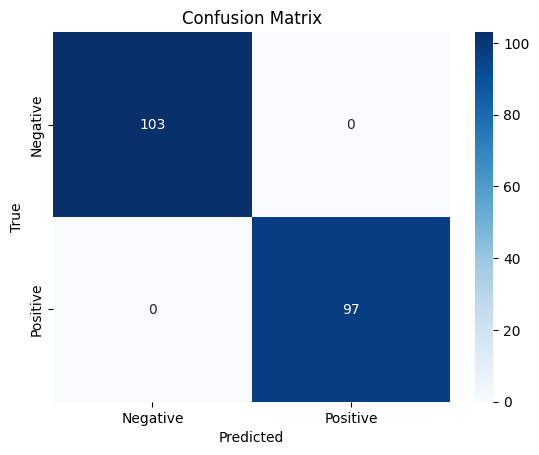

In [11]:
cm = confusion_matrix(y_valid, preds)
# Plot confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()